# Topic 1: Hotel Reservation Cancellation Prediction

## Context

A hotel is need in support to increase revenue from their room bookings. They believe that they can use data science to help then reduce the number of cancellations by identify what contributes to whether a booking will be fulfilled or cancelled.

## Questions

- What factor affect whether customers cancel their booking?
- Which general recommendations for the hotel can we make?

## Data Description

- **Booking_ID**: unique identifier of each booking
- **no_of_adults**: Number of adults
- **no_of_children**: Number of Children
- **no_of_weekend_nights**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **no_of_week_nights**: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **type_of_meal_plan**: Type of meal plan booked by the customer:
- **required_car_parking_space**: Does the customer require a car parking space? (0 - No, 1- Yes)
- **room_type_reserved**: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- **lead_time**: Number of days between the date of booking and the arrival date
- **arrival_year**: Year of arrival date
- **arrival_month**: Month of arrival date
- **arrival_date**: Date of the month
- **market_segment_type**: Market segment designation.
- **repeated_guest**: Is the customer a repeated guest? (0 - No, 1- Yes)
- **no_of_previous_cancellations**: Number of previous bookings that were canceled by the customer prior to the current booking
- **no_of_previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking
- **avg_price_per_room**: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- **no_of_special_requests**: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- **booking_status**: Flag indicating if the booking was canceled or not.

In [246]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

from scipy.stats import ttest_ind

## 1. Basic Exploration

In [4]:
df = pd.read_csv('Hotel Reservations.csv', index_col='Booking_ID')
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [5]:
# Examining the shape of the dataset
df.shape

(36275, 18)

- The dataset has **36275 rows and 18 columns**.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36275 entries, INN00001 to INN36275
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_seg

**Observations:**

- Only `type_of_meal_plan`, `room_type_reserved`, `market_segment_type`, `booking_status` are of object type, the rest of the columns are of numeric type.
- There is **no null values** in the dataset.

In [8]:
# Checking for duplicate values
df.duplicated().sum()

10275

- There are 10275 duplicate rows in the dataset, ignoring the `Booking_ID` as index.
- Filter out these duplicate rows is required.

In [9]:
df = df.drop_duplicates()
df.shape

(26000, 18)

- After duplication drop, there are only 26k rows left.

## 2. Exploratory Data Analysis

### Univariate Analysis

In [10]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,26000.0,1.890000,0.528702,0.0,2.00,2.0,2.0,4.0
no_of_children,26000.0,0.141231,0.462502,0.0,0.00,0.0,0.0,10.0
no_of_weekend_nights,26000.0,0.882385,0.887371,0.0,0.00,1.0,2.0,7.0
no_of_week_nights,26000.0,2.261923,1.512341,0.0,1.00,2.0,3.0,17.0
required_car_parking_space,26000.0,0.042115,0.200856,0.0,0.00,0.0,0.0,1.0
lead_time,26000.0,66.452846,68.606799,0.0,12.00,44.0,100.0,443.0
arrival_year,26000.0,2017.850269,0.356814,2017.0,2018.00,2018.0,2018.0,2018.0
arrival_month,26000.0,7.332923,3.138925,1.0,5.00,8.0,10.0,12.0
arrival_date,26000.0,15.750231,8.849394,1.0,8.00,16.0,23.0,31.0
repeated_guest,26000.0,0.032769,0.178035,0.0,0.00,0.0,0.0,1.0


**Observations:**

- `no_of_adults`: The minimum number of adults is zero which seems to be unusual in this case. We assume that there is the case where children are sent to the hotel by the elders. To ensure that no "ghost" comes, we will see whether there is a booking with no adult and no child to drop out those records. Maximum number of adults is 4.
- `no_of_children`: Average number of children for a booking is 0.14 indicating that not much children included in the bookings. The maximum is 10 which can be a potential outlier.
- `no_of_weekend_nights`: Average number of weekend nights is 0.88, maximum number of 7 could be extreme since people has to stay in 3 consecutive weeks and the probability of scamming for this case can be relatively high.
- `no_of_week_nights`: Average number of week nights is 2.2, maximum of 17 includes the same possibility as in the above feature.
- `required_car_parking_space`: Suppose to be a boolean value of 0 and 1 with 4% of True.
- `lead_time`: A continuous variable ranging from 0 (immediate booking) to 443.
- `arrival_year`: Show that the data was collected from 2017 to 2018.
- `arrival_month`, `arrival_date`: Ranging from 1 to 12 and 1 to 31 respectively, which is reasonable.
- `repeated_guest`: Suppose to be a boolean value with 3% of True.
- `no_of_previous_cancellations`: Over 75% of booking contain zero previous cancellations.
- `no_of_previous_bookings_not_canceled`: Over 75% of booking contain zero successful bookings. It seems like most guest are new here considering the last 3 features.
- `avg_price_per_room`: Average of 105, but seem weird with the existance of zeros. However there could be the case that the hotel offer a 100% discount for the booking, in real-world case, we could ask for the "manager" to know more about this. But for now, we will keep this column.
- `no_of_special_requests`: Commonly to have at least 1 request, and the average of request is 0.74.

In [27]:
# Remove record with no people
no_people = (df['no_of_adults'] + df['no_of_children'] == 0)
print("There are {} records with zero people booked".format(no_people.sum()))
df = df[~no_people]

There are 0 records with zero people booked


- Gladly that if a booking has zero adult, is must have at least 1 child.

In [23]:
# Split the columns
categorical_cols = list(df.select_dtypes("object").columns)
boolean_cols = ['required_car_parking_space', 'repeated_guest']
date_cols = ['arrival_year', 'arrival_month', 'arrival_date']
numerical_cols = list(df.columns.difference(categorical_cols + boolean_cols + date_cols))

In [25]:
print("Categorical columns: ", categorical_cols)
print("Boolean columns: ", boolean_cols)
print("Date columns: ", date_cols)
print("Numerical columns: ", numerical_cols)

Categorical columns:  ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']
Boolean columns:  ['required_car_parking_space', 'repeated_guest']
Date columns:  ['arrival_year', 'arrival_month', 'arrival_date']
Numerical columns:  ['avg_price_per_room', 'lead_time', 'no_of_adults', 'no_of_children', 'no_of_previous_bookings_not_canceled', 'no_of_previous_cancellations', 'no_of_special_requests', 'no_of_week_nights', 'no_of_weekend_nights']


**Categorical variables** (Booleans included)

In [16]:
for col in categorical_cols + boolean_cols:
    print(df[col].value_counts(normalize=True))
    print('-' * 50)

Meal Plan 1     0.784538
Not Selected    0.171654
Meal Plan 2     0.043615
Meal Plan 3     0.000192
Name: type_of_meal_plan, dtype: float64
--------------------------------------------------
Room_Type 1    0.716923
Room_Type 4    0.208577
Room_Type 6    0.036269
Room_Type 2    0.023077
Room_Type 5    0.008923
Room_Type 7    0.006000
Room_Type 3    0.000231
Name: room_type_reserved, dtype: float64
--------------------------------------------------
Online           0.769962
Offline          0.158154
Corporate        0.054308
Complementary    0.013731
Aviation         0.003846
Name: market_segment_type, dtype: float64
--------------------------------------------------
Not_Canceled    0.713769
Canceled        0.286231
Name: booking_status, dtype: float64
--------------------------------------------------
0    0.957885
1    0.042115
Name: required_car_parking_space, dtype: float64
--------------------------------------------------
0    0.967231
1    0.032769
Name: repeated_guest, dtype: flo

**Observations:**

- Most of the meal plan and room type are Meal Plan 1 and Room_Type 1. They seem to be the default option for booking.
- Most of the booking are online.
- The target variable, `booking_status` shows an imbalance between 2 classes since there are 71% of records are `Not_Canceled`. This should be considered in further steps.
- The majority of booking require no parking space. And most booking are from new guest as stated in the previous section.

In [15]:
# Checking the uniqueness in ID
df.index.nunique(), len(df)

(26000, 26000)

- All the IDs are unique.

**Numerical variables**

Column:  avg_price_per_room
Skewness:  0.59


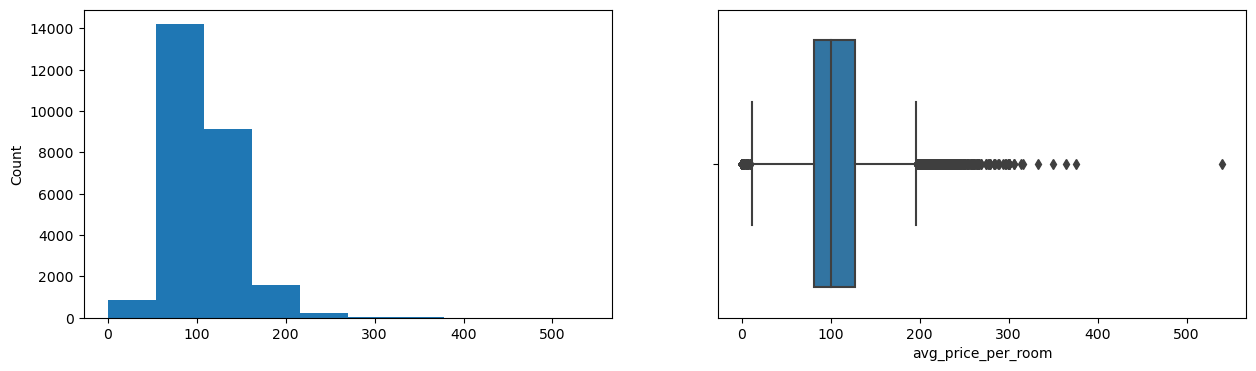

Column:  lead_time
Skewness:  1.41


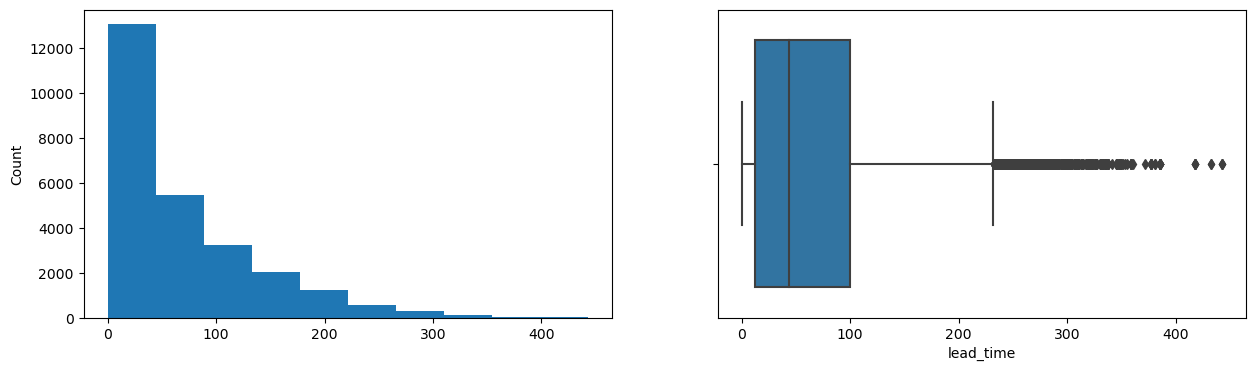

Column:  no_of_adults
Skewness:  -0.3


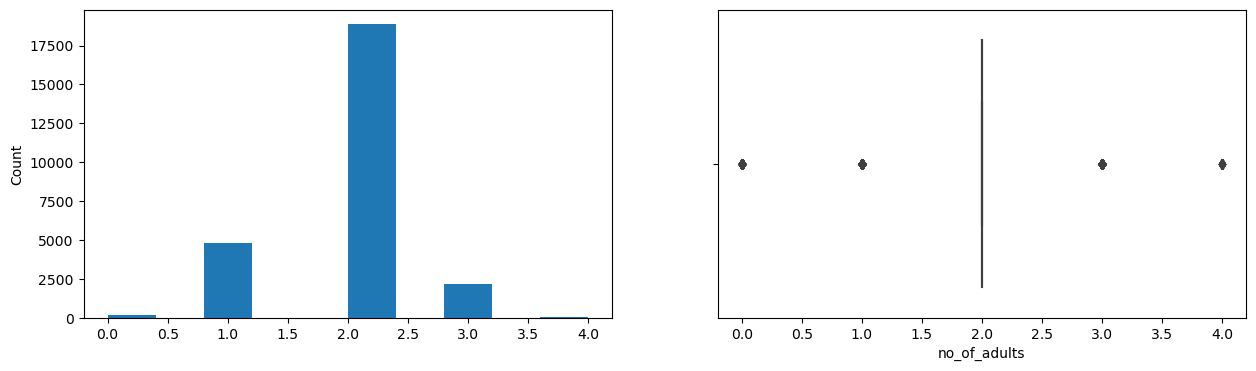

Column:  no_of_children
Skewness:  4.01


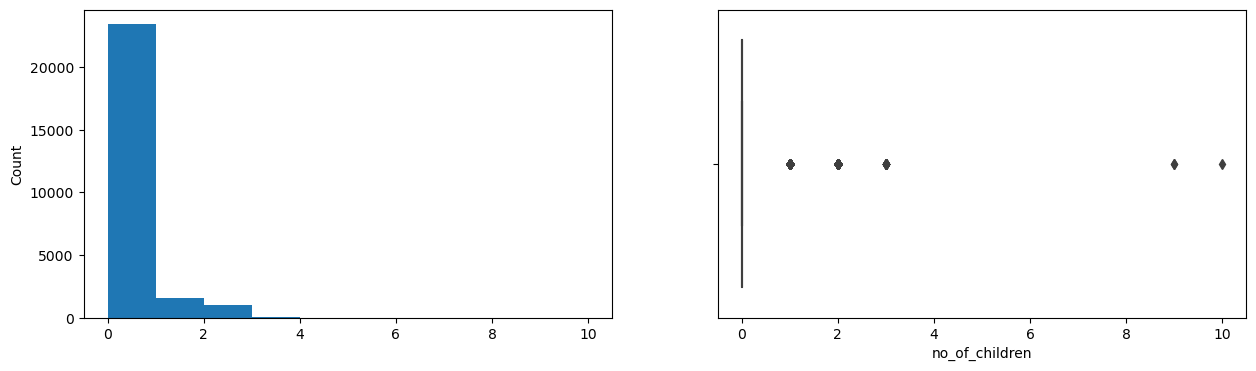

Column:  no_of_previous_bookings_not_canceled
Skewness:  16.3


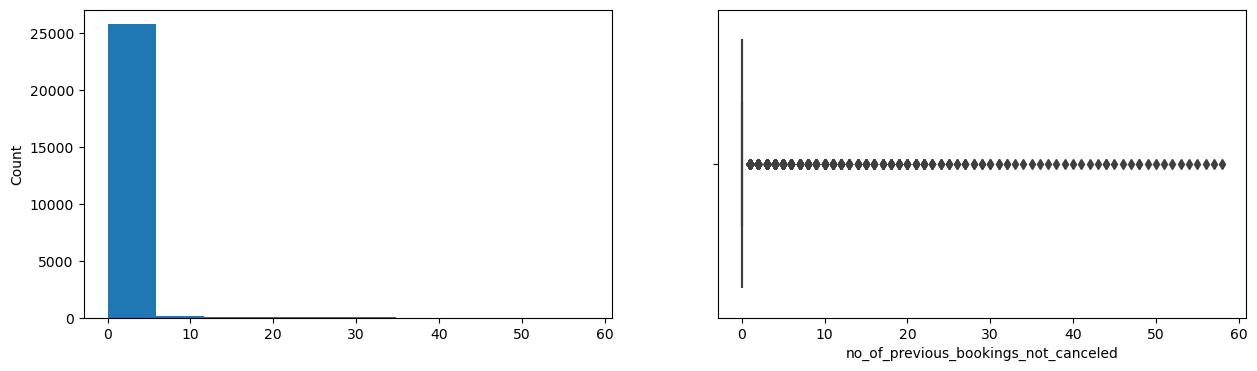

Column:  no_of_previous_cancellations
Skewness:  21.94


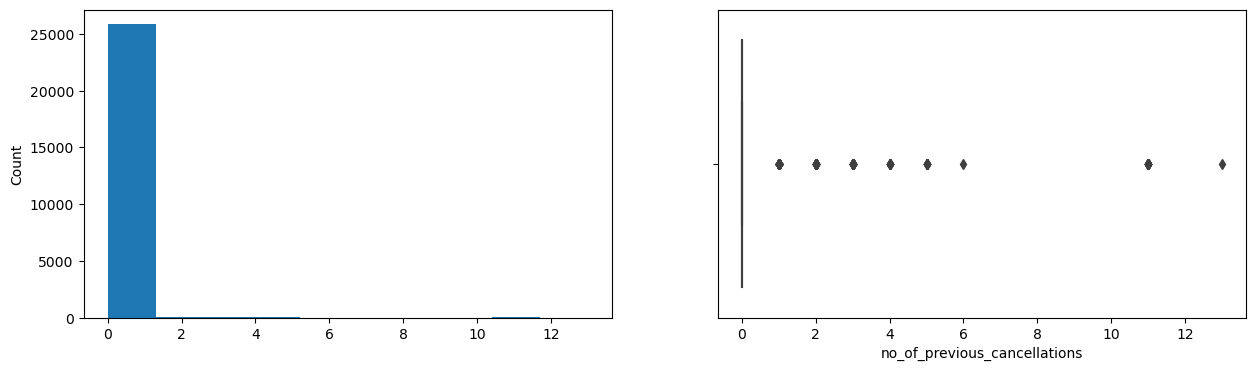

Column:  no_of_special_requests
Skewness:  0.91


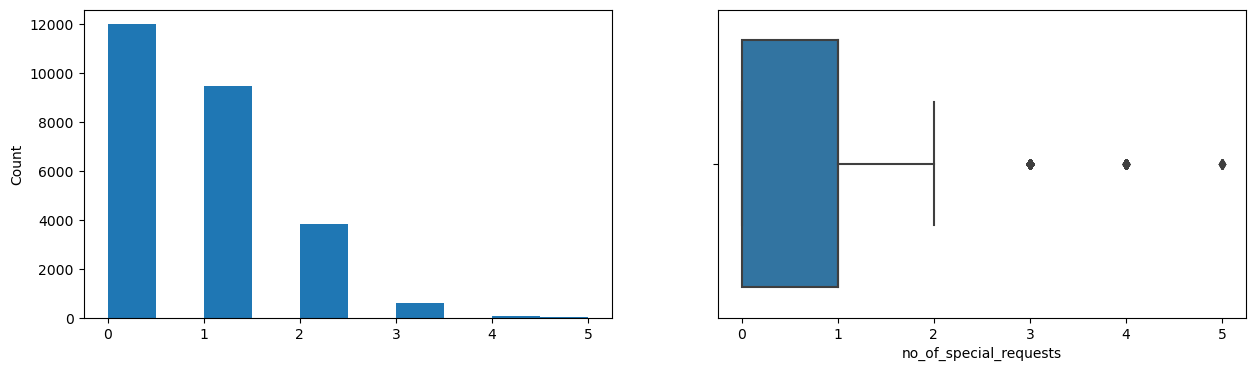

Column:  no_of_week_nights
Skewness:  1.6


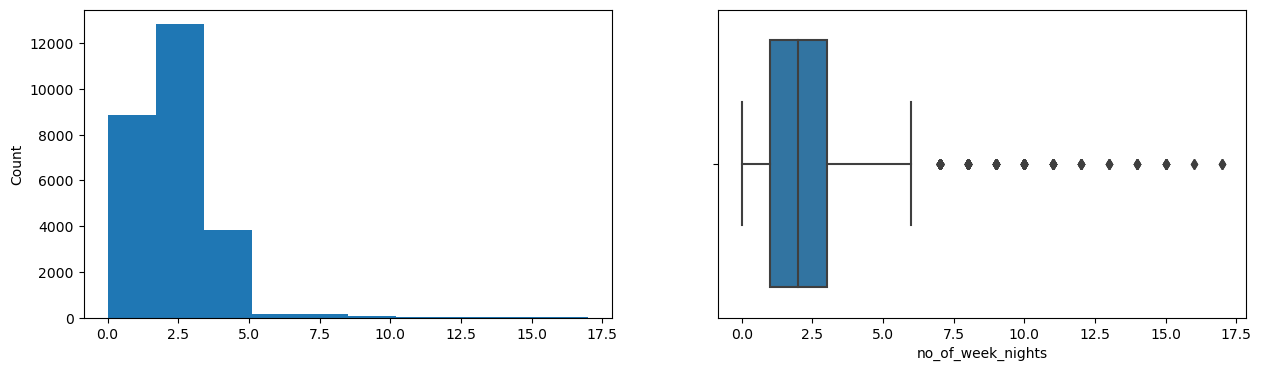

Column:  no_of_weekend_nights
Skewness:  0.66


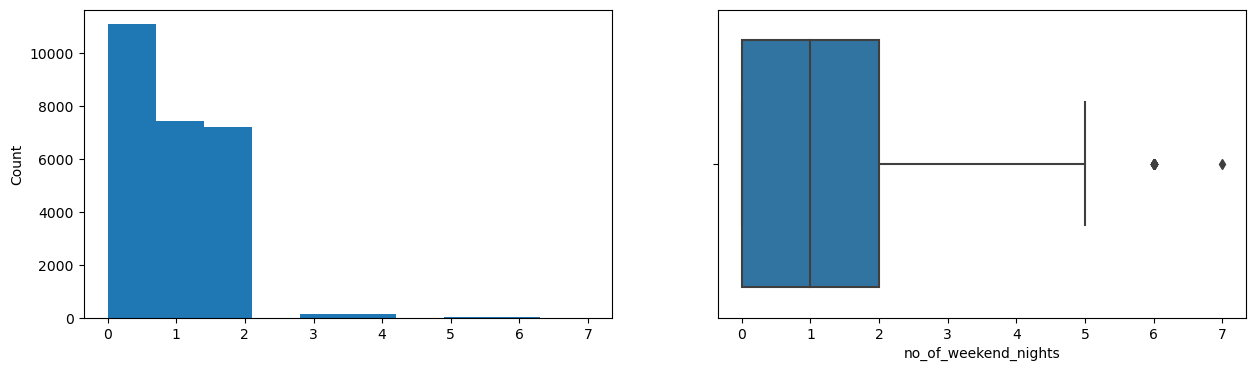

In [26]:
for col in numerical_cols:
    print("Column: ", col)
    print("Skewness: ", round(df[col].skew(), 2))
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    df[col].hist(bins=10, grid=False)
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

**Observations:**

- `avg_price_per_room`: The majority of bookings have the price around 100 euros. There are a number of outliers past both Q1 and Q3 percentiles.
- `lead_time`: Lead time is **heavily right skewed** with most of short booking (i.e., arrival in a few days after booking).
- `no_of_previous_bookings_not_canceled`, `no_of_previous_cancellations`: Mostly 0, therefore we can convert this into categorical variables which indicate the status of their previous booking (if any).
- `no_of_special_requests`: Goes down constantly from 0 to 5.
- `no_of_week_nights`: Right skewed and around 2 nights, there are a number of outliers exceeding 6 nights.
- `no_of_weekend_nights`: Right skewed and mostly 0-2 nights, there are a number of outliers exceeding 5 nights.

In [29]:
df['has_cancelled_booking'] = df['no_of_previous_cancellations'] > 0
df['has_successful_booking'] = df['no_of_previous_bookings_not_canceled'] > 0
df = df.drop(['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'], axis=1)

In [30]:
for col in ['has_cancelled_booking', 'has_successful_booking']:
    print(df[col].value_counts(normalize=True))
    print('-' * 50)

False    0.989654
True     0.010346
Name: has_cancelled_booking, dtype: float64
--------------------------------------------------
False    0.969231
True     0.030769
Name: has_successful_booking, dtype: float64
--------------------------------------------------


In [40]:
# 'has_cancelled_booking', 'has_successful_booking' already indicate that is has a repeated guest
has_booking = df[['has_cancelled_booking', 'has_successful_booking']].sum(axis=1) > 1
(has_booking == df['repeated_guest']).sum()

25365

- `has_cancelled_booking` and `has_successful_booking` already indicate that is the corresponding customer is a `repeated_guest`. But it seems not to be the case for all records but only 25365/26000 rows would have this property. It should be something that we report, but up to now we will removing the `repeated_guest` column.

In [42]:
df = df.drop("repeated_guest", axis=1)

### Bivariate Analysis

Categorical/Target:

In [43]:
# Add more columns to boolean
label_col = 'booking_status'
boolean_cols += ['has_cancelled_booking', 'has_successful_booking']
boolean_cols.remove('repeated_guest')

# Removing label_column
categorical_cols.remove(label_col)

Column:  required_car_parking_space


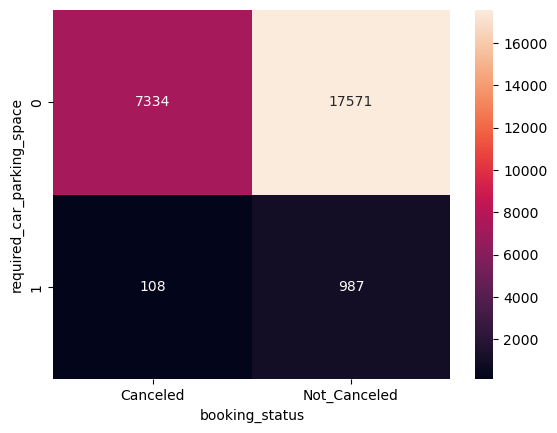

Column:  has_cancelled_booking


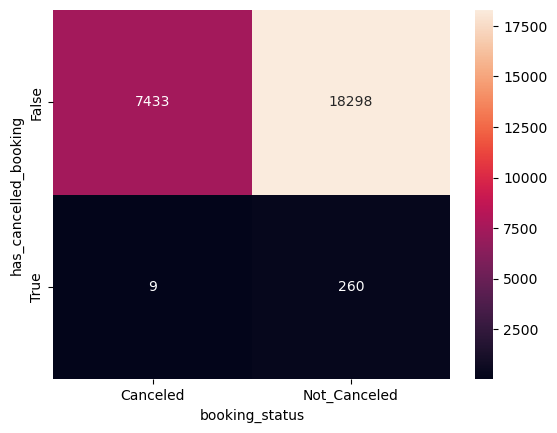

Column:  has_successful_booking


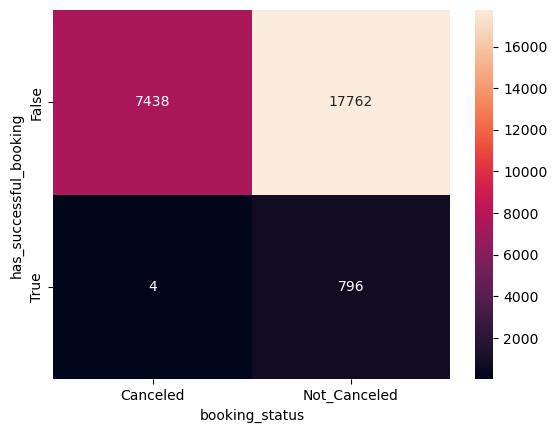

In [48]:
for col in boolean_cols:
    print("Column: ", col)
    plt.figure()
    sns.heatmap(pd.crosstab(df[col], df[label_col]), annot=True, fmt='g')
    plt.show()

**Observations:**

- For major classes (no parking space required, has no cancelled booking, has no successful booking), the rate of cancelation is approximately 2/5 compare to the number of not cancelation.
- On the other hand, minor class would induce mostly a guarantee for availability to arrive.

Column:  type_of_meal_plan


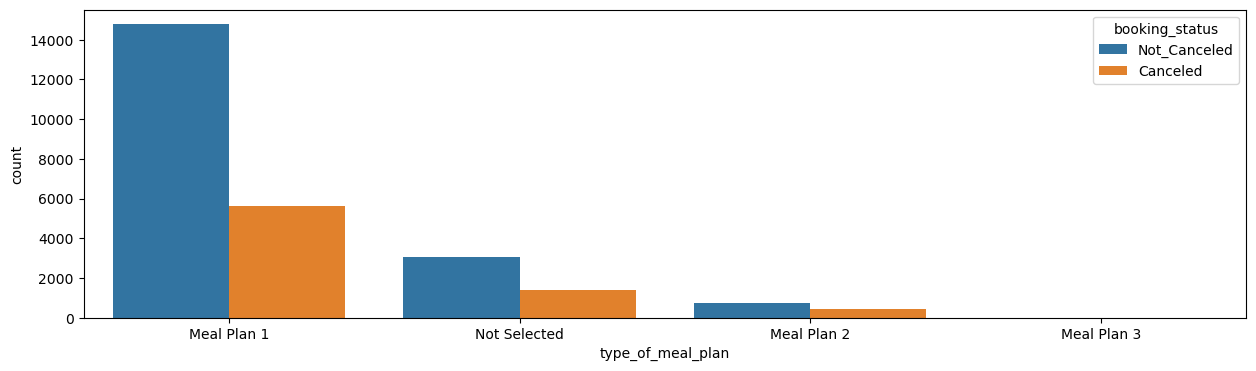

Column:  room_type_reserved


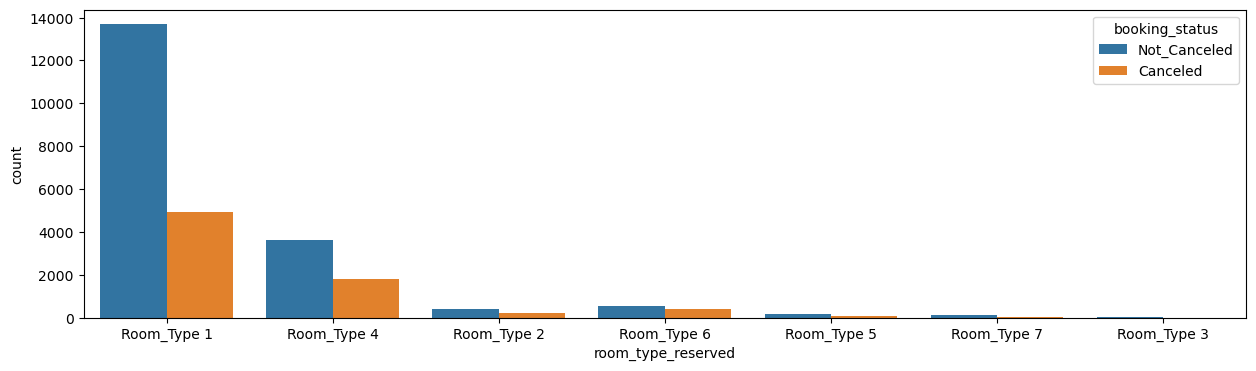

Column:  market_segment_type


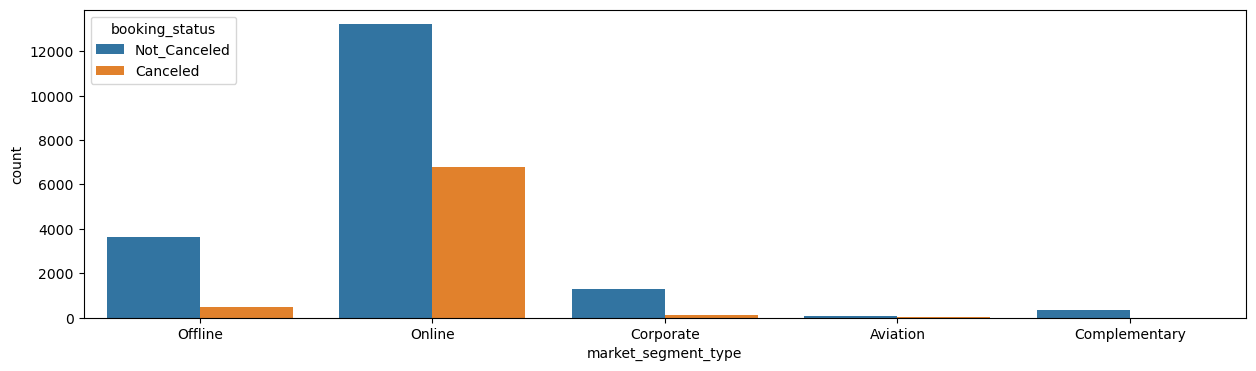

In [52]:
for col in categorical_cols:
    print("Column: ", col)
    plt.figure(figsize=(15,4))
    sns.countplot(x=col, hue=label_col, data=df)
    plt.show()

**Observations:**
- `type_of_meal_plan` and `room_type_reserved` do not have significant difference between the proportion of cancelled and non-cancelled booking between classes.
- `market_segment_type`: The likelihood of cancellation in online order is greater than any other type of market segment.

Numerical/Target

In [58]:
numerical_cols.remove('no_of_previous_cancellations')
numerical_cols.remove('no_of_previous_bookings_not_canceled')

Column:  avg_price_per_room


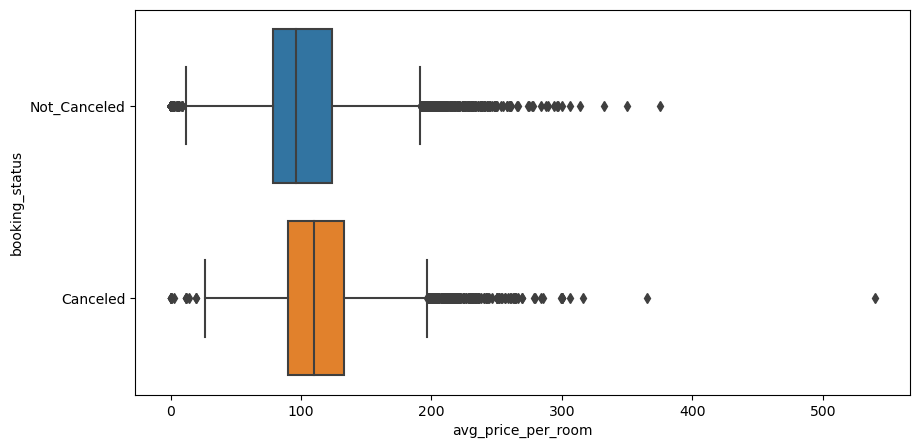

Column:  lead_time


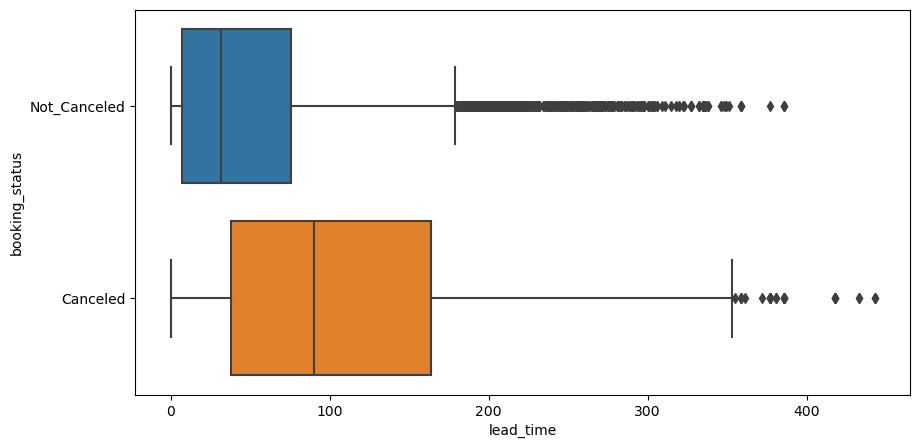

Column:  no_of_adults


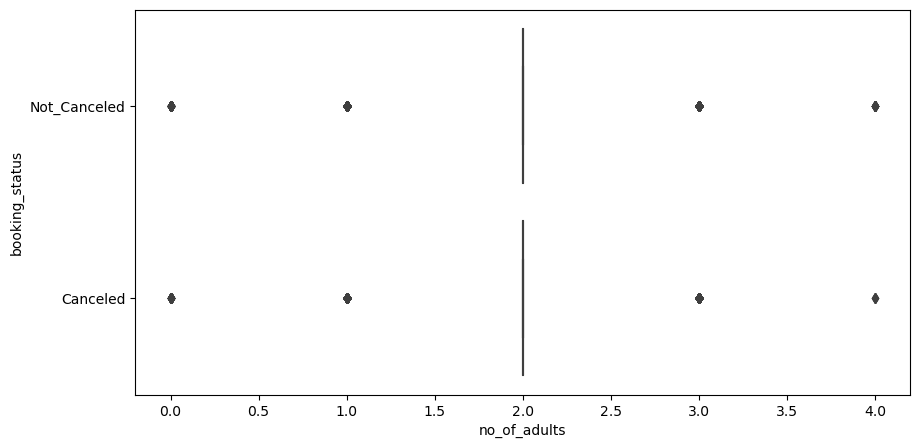

Column:  no_of_children


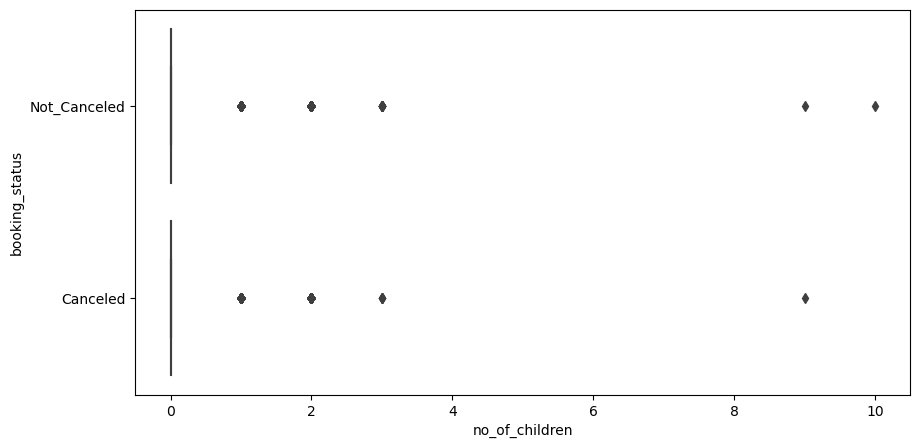

Column:  no_of_special_requests


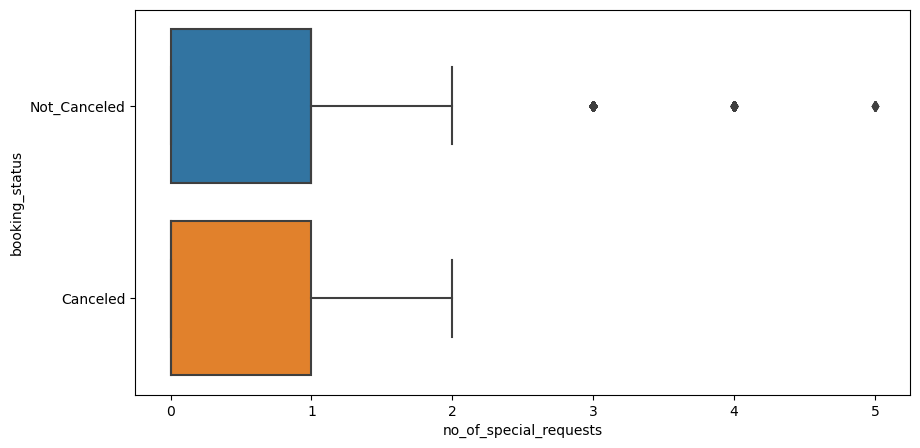

Column:  no_of_week_nights


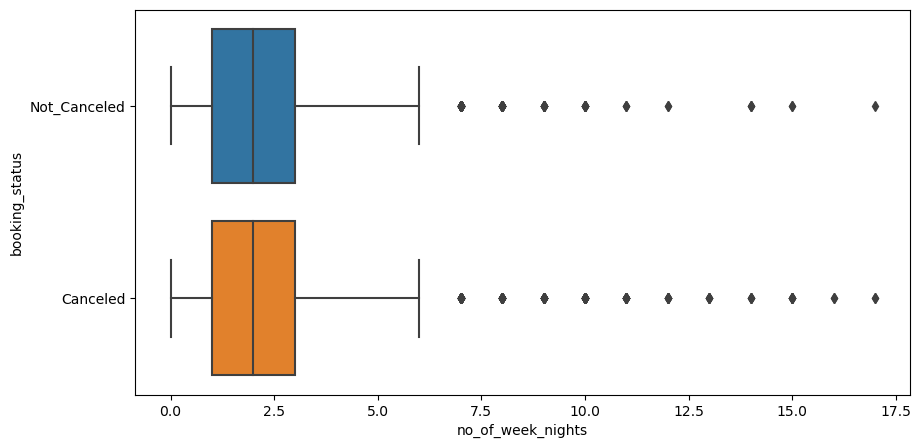

Column:  no_of_weekend_nights


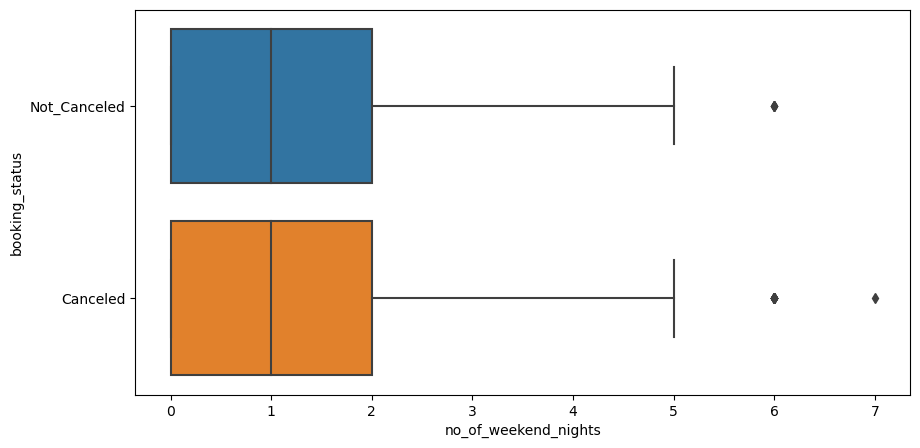

In [59]:
for col in numerical_cols:
    print("Column: ", col)
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y=label_col, data=df)
    plt.show()

**Observations**:
- `lead_time` was the only feature that shows a great difference in distribution between cancelled and non-cancelled booking. This should be a potential feature for prediction.

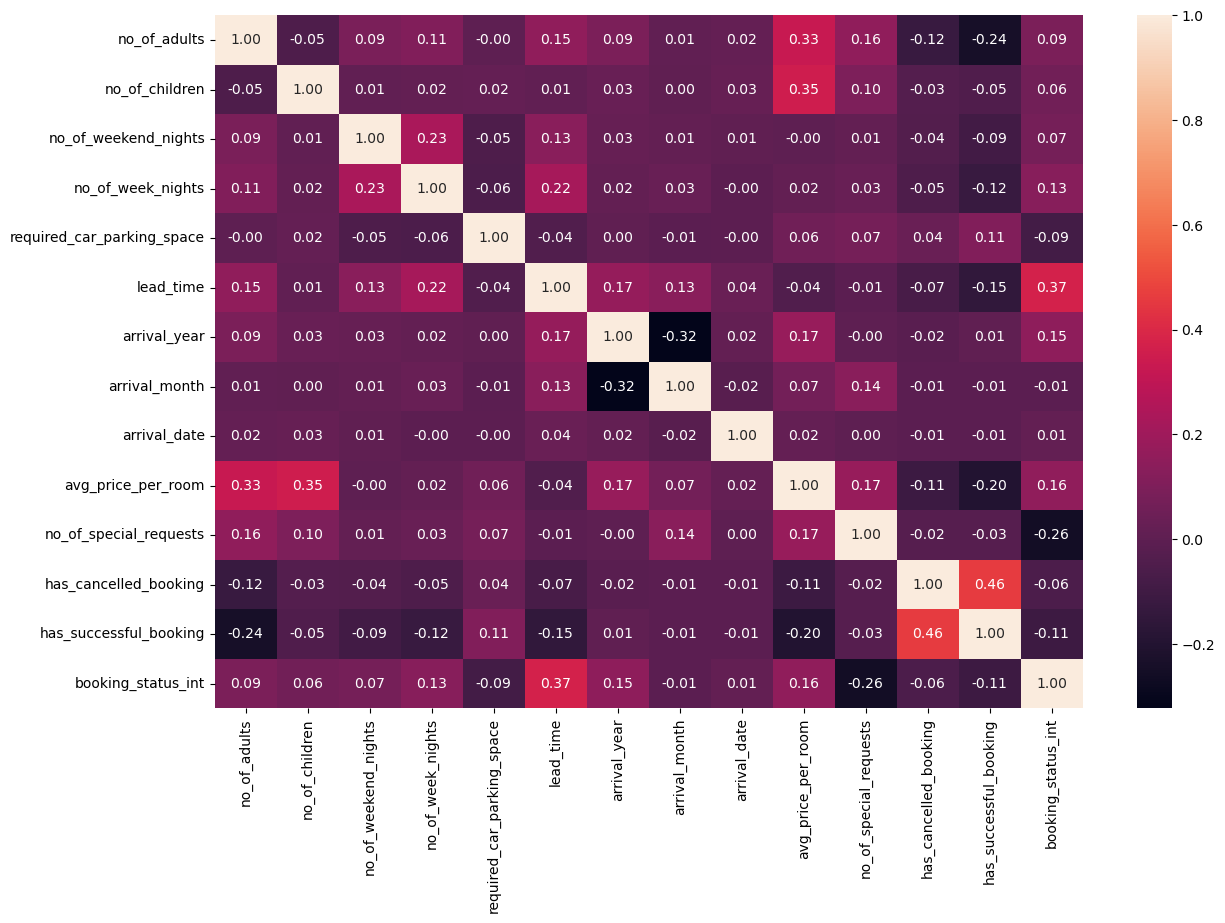

In [61]:
plt.figure(figsize=(14,9))
df['booking_status_int'] = df['booking_status'] == 'Canceled'
sns.heatmap(df.corr(), annot = True, fmt = '.2f')
plt.show()

**Observations:**

- Without the label, the highest correlation is positive between `avg_price_per_room` and `no_of_adults` + `no_of_children`, shows that more people afford to pay for higher room price.
- Compare to our target column, `lead_time` shows the highest positive correlation, and `no_of_special_request` shows a negative negative correlation. Two conclusion can be made:
    - Higher lead time leads to higher chance of being canceled.
    - Higher number of special requests leads to higher certainty that the customer would arrive.

**Time-related features:**

Column:  arrival_year


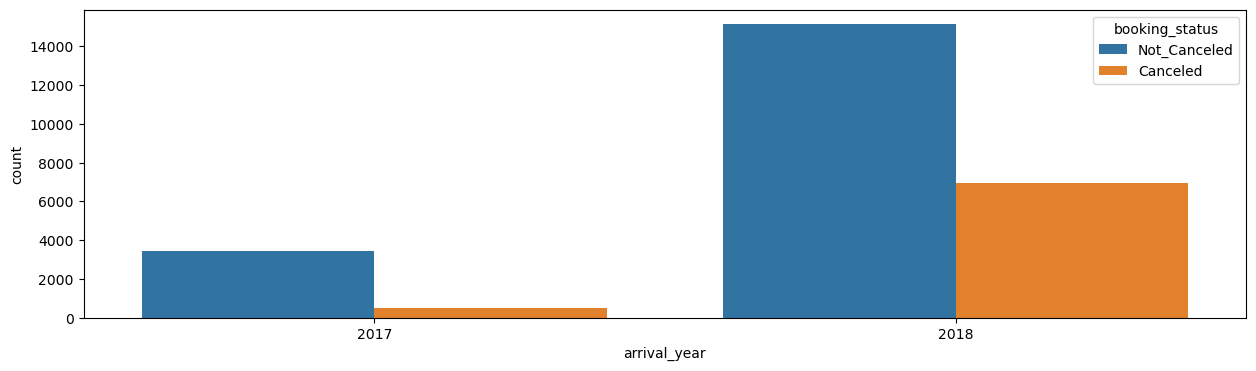

Column:  arrival_month


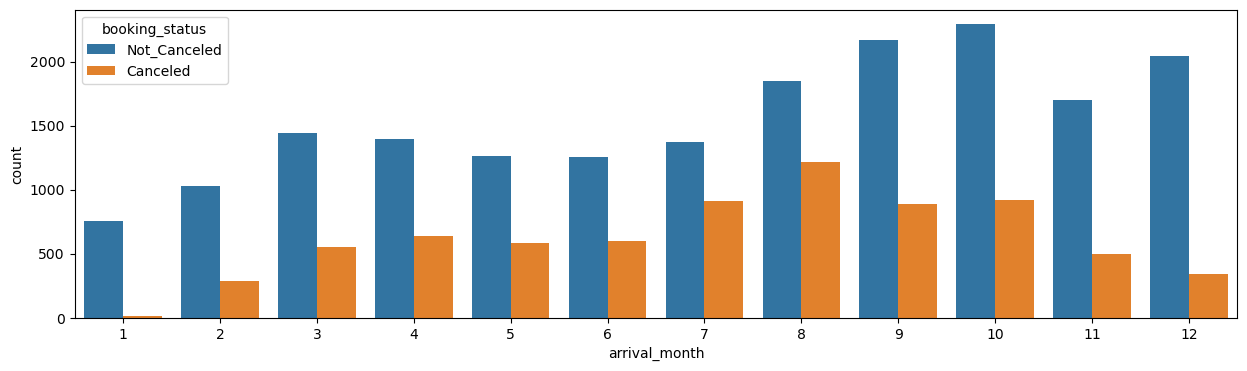

Column:  arrival_date


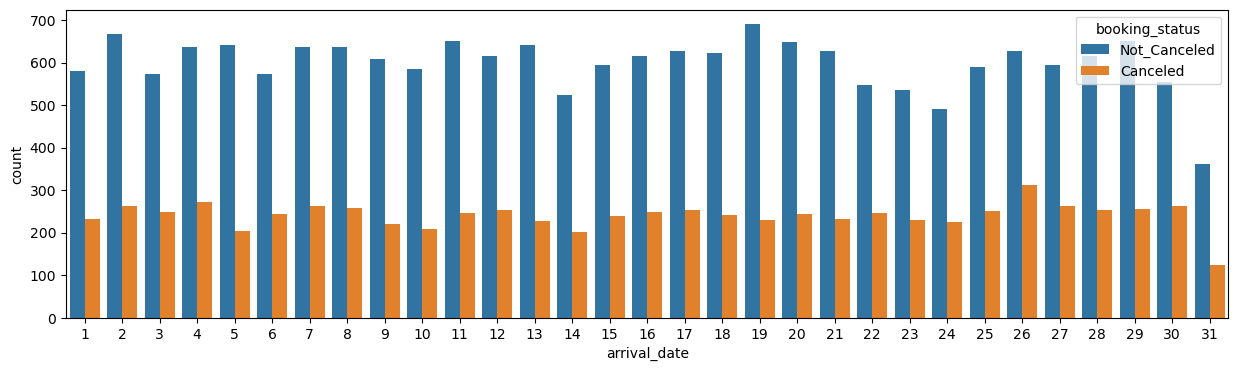

In [62]:
for col in date_cols:
    print("Column: ", col)
    plt.figure(figsize=(15,4))
    sns.countplot(x=col, hue=label_col, data=df)
    plt.show()

**Observations:**

- The number of bookings in 2018 went up along with the chance of being cancelled.
- The lowest proportion of non-cancellation booking is through November to Febrary. Highest number of booking were made on October, highest number of cancellation were made during summer (July, August).
- Number of booking throughout the days of the month is quite similar with no clear exceptional pattern.

In [64]:
# Convert arrival month to categorical
df['arrival_month'] = df['arrival_month'].astype('category')

# Remove arrival year and date
df = df.drop(['arrival_year', 'arrival_date'], axis=1)

In [65]:
# Drop the label column since we have convert it into number in `booking_status_int`
df = df.drop('booking_status', axis=1)

## 3. Modelling

### Objective

We are aiming to create a model that correctly predict whether a booking is fraud, where `1` is the booking is cancelled while `0` is not.

The metrics that lead to our focus here is F1-score since we are dealing with imbalance dataset.

In some cases, if the manager wants to earn correct prediction regardless of the class imbalance, we can expect to have high accuracy.

In [118]:
# Encoding categorical features
X = df.drop('booking_status_int', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['booking_status_int']

# Recapture the features
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26000 entries, INN00001 to INN36274
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   no_of_adults                       26000 non-null  int64  
 1   no_of_children                     26000 non-null  int64  
 2   no_of_weekend_nights               26000 non-null  int64  
 3   no_of_week_nights                  26000 non-null  int64  
 4   required_car_parking_space         26000 non-null  int64  
 5   lead_time                          26000 non-null  int64  
 6   avg_price_per_room                 26000 non-null  float64
 7   no_of_special_requests             26000 non-null  int64  
 8   has_cancelled_booking              26000 non-null  bool   
 9   has_successful_booking             26000 non-null  bool   
 10  type_of_meal_plan_Meal Plan 2      26000 non-null  uint8  
 11  type_of_meal_plan_Meal Plan 3      26000 non-null

In [119]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [120]:
print("Shape of the training set: ", X_train.shape)   
print("Shape of the test set: ", X_test.shape)
print("Percentage of classes in the training set:")
print(y_train.value_counts(normalize = True))
print("Percentage of classes in the test set:")
print(y_test.value_counts(normalize = True))

Shape of the training set:  (18200, 34)
Shape of the test set:  (7800, 34)
Percentage of classes in the training set:
False    0.713462
True     0.286538
Name: booking_status_int, dtype: float64
Percentage of classes in the test set:
False    0.714487
True     0.285513
Name: booking_status_int, dtype: float64


To deal with imbalance, we will use oversampling and undersampling techniques. In specific, we will use SMOTE for oversampling and ENN for undersampling. And Random Forest will be used for classification.

In [139]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

In [140]:
smote = SMOTE()
smote_X, smote_y = smote.fit_resample(X_train, y_train)

e = EditedNearestNeighbours()
r_X, r_y = e.fit_resample(smote_X, smote_y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(r_X, r_y)

RandomForestClassifier(random_state=42)

In [141]:
# Evaluation on training set
y_pred_train = rf.predict(X_train)
print(classification_report(y_train, y_pred_train, digits=4))

              precision    recall  f1-score   support

       False     0.9164    0.9992    0.9560     12985
        True     0.9975    0.7732    0.8711      5215

    accuracy                         0.9345     18200
   macro avg     0.9570    0.8862    0.9136     18200
weighted avg     0.9397    0.9345    0.9317     18200



In [142]:
# ROC AUC score
roc_auc_score(y_train, y_pred_train)

0.8861921215238026

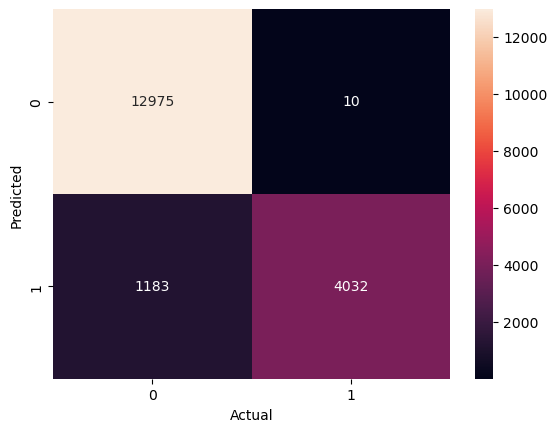

In [143]:
plt.figure()
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [144]:
# Evaluation on test set
y_pred_test = rf.predict(X_test)
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

       False     0.8599    0.9408    0.8985      5573
        True     0.8062    0.6165    0.6987      2227

    accuracy                         0.8482      7800
   macro avg     0.8331    0.7787    0.7986      7800
weighted avg     0.8446    0.8482    0.8415      7800



In [145]:
# ROC AUC score
roc_auc_score(y_pred_test, y_test)

0.8330777118517805

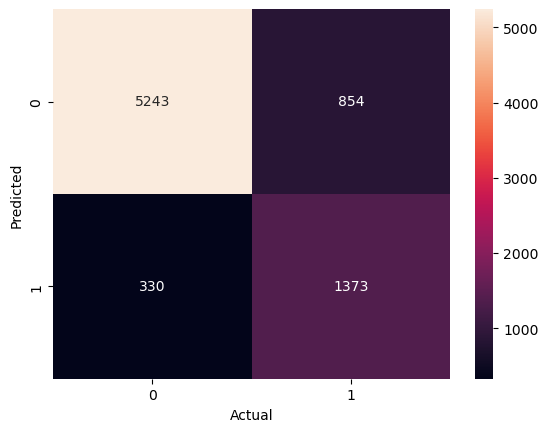

In [146]:
plt.figure()
sns.heatmap(confusion_matrix(y_pred_test, y_test), annot=True, fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

- The baseline model seems to be overfitted, with 91% F1-score on training set but 79% on test set. We will later use hyperparameter tuning for the best fit model.
- Also, the false positive rate is stll being high (since we want to get high precision of detecting potential cancellation in bookings).

**Hyperparameter tuning**

Instead of define a search space and perform a grid search, we will use auto-hyperparameter tuning from `auto-sklearn` library.

In [179]:
# Choose the type of classifier 
rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 7)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5, 20],
    'max_features': [0.8, 0.9],
    'class_weight': ["balanced", None]
}

# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = make_scorer(f1_score, pos_label = 1)

# Run the grid search on the training data using scorer=scorer and cv=3

grid_obj = GridSearchCV(rf_estimator_tuned, param_grid, scoring = scorer, cv=3, verbose=3)

grid_obj = grid_obj.fit(r_X, r_y)

# Save the best estimator to variable rf_estimator_tuned
rf_estimator_tuned = grid_obj.best_estimator_

#Fit the best estimator to the training data
rf_estimator_tuned.fit(r_X, r_y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=50;, score=0.803 total time=   0.6s
[CV 2/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=50;, score=0.859 total time=   0.6s
[CV 3/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=50;, score=0.859 total time=   0.5s
[CV 1/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=100;, score=0.803 total time=   1.1s
[CV 2/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=100;, score=0.865 total time=   1.1s
[CV 3/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=100;, score=0.863 total time=   1.1s
[CV 1/3] END class_weight=balanced, max_depth=5, max_features=0.8, min_samples_leaf=1, n_estimators=150;, score=0.804 

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.9, random_state=7)

              precision    recall  f1-score   support

       False     0.8937    0.9114    0.9025     12985
        True     0.7679    0.7302    0.7486      5215

    accuracy                         0.8595     18200
   macro avg     0.8308    0.8208    0.8255     18200
weighted avg     0.8577    0.8595    0.8584     18200

ROC AUC score:  0.8207803014836427
Confusion matrix: 


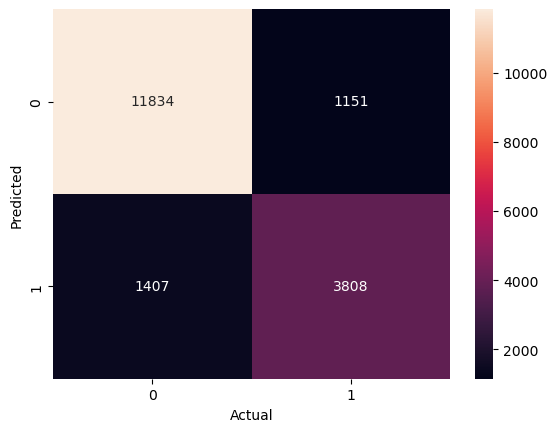

In [180]:
# Evaluation on training set
y_pred_train = rf_estimator_tuned.predict(X_train)
print(classification_report(y_train, y_pred_train, digits=4))
print("ROC AUC score: ", roc_auc_score(y_train, y_pred_train))
print("Confusion matrix: ")
plt.figure()
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

              precision    recall  f1-score   support

       False     0.8874    0.9047    0.8960      5573
        True     0.7493    0.7126    0.7305      2227

    accuracy                         0.8499      7800
   macro avg     0.8183    0.8087    0.8132      7800
weighted avg     0.8479    0.8499    0.8487      7800

ROC AUC score:  0.808668526672678
Confusion matrix: 


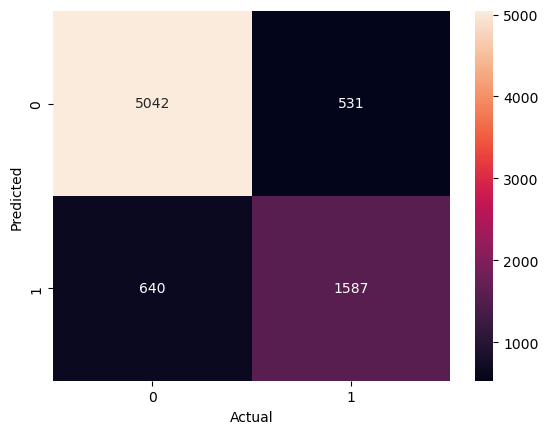

In [182]:
# Evaluation on test set
y_pred_test = rf_estimator_tuned.predict(X_test)
print(classification_report(y_test, y_pred_test, digits=4))
print("ROC AUC score: ", roc_auc_score(y_test, y_pred_test))
print("Confusion matrix: ")
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

**Observations:**

- The model is no longer overfitted with a testing F1-score of 81% and training F1-score of 83%, meaning it will generalize well.

**Feature importance**

In [183]:
display(pd.DataFrame(rf_estimator_tuned.feature_importances_, columns=["Importance"], index=X.columns).sort_values("Importance", ascending=False))

,Importance
lead_time,0.323796
no_of_special_requests,0.252101
avg_price_per_room,0.109335
market_segment_type_Offline,0.075419
market_segment_type_Online,0.073149
arrival_month_12,0.036576
market_segment_type_Corporate,0.030439
no_of_week_nights,0.022624
no_of_weekend_nights,0.014406
required_car_parking_space,0.014123


- Overall, `lead_time`, `no_of_special_request`, `avg_price_per_room`, `market_segment_type_Offline`, `market_segment_type_Online` are the feature with the highest importance scores.

## 4. Further Discussion

### Context

The company is trying to propose a strategy which limits the number of options to be chosen for first-time customer. Decide should it be a good choice to optimize the revenue while still be able to reduce the cancellation rate. If True, choose one of the following options:
- Limit the number of week/weekend nights.
- Limit the number of lead time.

**Hypothesis 1:** The chance of a booking from a first-time customer is cancelled is higher than repeated customer.

This one was proven from above analysis, where a customer with either `has_successful_booking` or `has_cancelled_booking` will less likely to cancel the booking.

**Hypothesis 2:** The average revenue comes from repeated customer is higher than first_time customer.

First we recalculate the amount of revenue get from every booking.

In [204]:
# NOTE: Revenue is made by assumption
df = df.rename(columns={"booking_status_int": "is_canceled"})
df['revenue'] = (df['avg_price_per_room'] * (df['no_of_week_nights'] + df['no_of_weekend_nights'] * 1.2) * (df['no_of_adults'] + df['no_of_children'] * 0.8)) * (1 - df['is_canceled'])
display(df[['avg_price_per_room', 'no_of_week_nights', 'no_of_weekend_nights', 'no_of_adults', 'no_of_children', 'is_canceled', 'revenue']])

,avg_price_per_room,no_of_week_nights,no_of_weekend_nights,no_of_adults,no_of_children,is_canceled,revenue
Booking_ID,,,,,,,
INN00001,65.00,2,1,2,0,False,416.000
INN00002,106.68,3,2,2,0,False,1152.144
INN00003,60.00,1,2,1,0,True,0.000
INN00004,100.00,2,0,2,0,True,0.000
INN00005,94.50,1,1,2,0,True,0.000
...,...,...,...,...,...,...,...
INN36270,216.00,1,0,2,2,True,0.000
INN36271,167.80,6,2,3,0,False,4228.560
INN36272,90.95,3,1,2,0,True,0.000


Then we perform the t-test to know the chance to reject the null hypothesis: *The average revenue comes from repeated customer is NOT higher than first_time customer.*

In [188]:
df['repeated_customer_modified'] = df['has_successful_booking'] * df['has_cancelled_booking']
df_first_time = df[df['repeated_customer_modified']]
df_repeated = df[~df['repeated_customer_modified']]

In [203]:
# perform a t-test to compare the means of the two groups
t, p = ttest_ind(df_first_time['revenue'], df_repeated['revenue'], equal_var=False, alternative="less")

# print the t-test result
print(f"t-statistic: {t:.2f}, p-value: {p:.2f}")

# print the mean of revenue of 2 type of customers
print(f"First time customer mean: {df_first_time['revenue'].mean():.2f}")
print(f"Repeated customer mean: {df_repeated['revenue'].mean():.2f}")

# check if the p-value is less than 0.05 (at a 95% confidence level)
if p < 0.05:
    print("The hypothesis is supported: the average revenue from repeated customers is higher than first-time customers.")
else:
    print("The hypothesis is not supported: the average revenue from repeated customers is not higher than first-time customers.")

t-statistic: -33.25, p-value: 0.00
First time customer mean: 138.46
Repeated customer mean: 486.42
The hypothesis is supported: the average revenue from repeated customers is higher than first-time customers.


**Hypothesis 3:** Higher number of week/weekend nights leads to high risk of being cancelled.

This was proven via the correlation heatmap, but other proof can be made as we see an increase in proportion of cancellation throughout number of week/weekdays nights.

<AxesSubplot:xlabel='no_of_week_nights'>

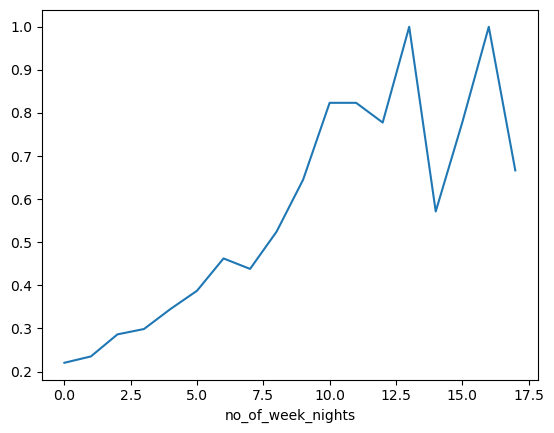

In [217]:
(df.groupby('no_of_week_nights')['is_canceled'].sum() / df.groupby('no_of_week_nights')['is_canceled'].count()).plot()

<AxesSubplot:xlabel='no_of_weekend_nights'>

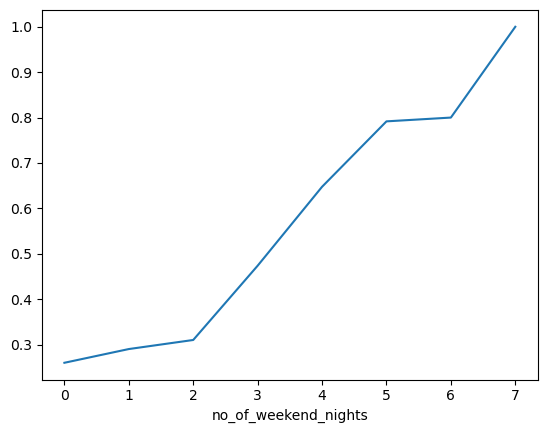

In [237]:
(df.groupby('no_of_weekend_nights')['is_canceled'].sum() / df.groupby('no_of_weekend_nights')['is_canceled'].count()).plot()

To get a small cancellation rate, once can limit the number booking days for first-time customer up to $n$ week nights and $m$ weekend nights. $n$ and $m$ can be identified from the below table.

In [275]:
week_nights_options = range(5, 16) # n 
weekend_nights_options = range(2, 6) # m

nights_strategies = []

for week in week_nights_options:
    for weekend in weekend_nights_options:
        result_dict = {}
        condition = ((df['no_of_week_nights'] < week) & (df['no_of_weekend_nights'] < weekend)) | (df['repeated_customer_modified'])
        df_conditioned = df[condition]
        df_against_condition = df[~condition]
        result_dict['week_nights'] = week
        result_dict['weekend_nights'] = weekend
        result_dict['n_records'] = len(df_conditioned)
        result_dict['n_cancelations_removed'] = df_against_condition['is_canceled'].sum()
        result_dict['n_success_removed'] = (1 - df_against_condition['is_canceled']).sum()
        result_dict['cancellation_rate'] = round(df_conditioned['is_canceled'].mean(), 4)
        result_dict['average_revenue'] = round(df_conditioned['revenue'].mean(), 2)
        nights_strategies.append(result_dict)

df_summary_nights = pd.DataFrame(nights_strategies)
df_summary_nights['savings'] = round(df_summary_nights['average_revenue'] * (df_summary_nights['n_cancelations_removed'] - df_summary_nights['n_success_removed']))
display(df_summary_nights.sort_values('savings', ascending=False))

,week_nights,weekend_nights,n_records,n_cancelations_removed,n_success_removed,cancellation_rate,average_revenue,savings
15,8,5,25805,135,60,0.2832,481.79,36134.0
18,9,4,25801,136,63,0.2832,481.01,35114.0
19,9,5,25866,103,31,0.2837,483.07,34781.0
14,8,4,25750,161,89,0.2828,479.80,34546.0
22,10,4,25822,124,54,0.2834,481.35,33694.0
10,7,4,25657,206,137,0.2820,478.23,32998.0
23,10,5,25897,83,20,0.2842,483.45,30457.0
26,11,4,25833,115,52,0.2836,481.48,30333.0
34,13,4,25833,115,52,0.2836,481.48,30333.0
42,15,4,25833,115,52,0.2836,481.48,30333.0


If we limit the number of week nights to `8` and the number of weekday nights to `5`, 36k euros can be save theoretically. 

In [257]:
lean_limit_options = range(0, 400, 30)

lean_limit_strategies = []

for lead_limit in lean_limit_options:
    result_dict = {}
    condition = (df['lead_time'] < lead_limit) | (df['repeated_customer_modified'])
    df_conditioned = df[condition]
    result_dict['lead_time_limit'] = lead_limit
    result_dict['n_records'] = len(df_conditioned)
    result_dict['cancellation_rate'] = round(df_conditioned['is_canceled'].mean(), 2)
    result_dict['average_revenue'] = round(df_conditioned['revenue'].mean(), 2)
    lean_limit_strategies.append(result_dict)

display(pd.DataFrame(lean_limit_strategies))

,lead_time_limit,n_records,cancellation_rate,average_revenue
0,0,217,0.02,138.46
1,30,10373,0.14,471.03
2,60,15263,0.18,496.20
3,90,18628,0.20,510.03
4,120,20968,0.22,514.78
5,150,22623,0.23,520.04
6,180,23863,0.25,505.86
7,210,24742,0.27,496.70
8,240,25276,0.28,491.06
9,270,25599,0.28,488.11


We can decide to limit the `lead_time` up to 150 days (5 months) for first booking. However, we can also apply the complex calculation to estimating the best value.

## 5. Conclusion and Recommendations

**Q: What factor affect whether customers cancel their booking?**

A:
- Unlimited settings of lead time can make people easy to cancel their bookings.
- Higher number of special requests leads to higher certainty that the customer would arrive. Special request is a great indicator of certain booking.
- First-time customer has more chance to cancel their bookings.
- Room price is a minor factor to the choice of cancellation.
- Outliers of week nights and weekday nights show the potential of scamming bookings.

**Q: Which general recommendations for the hotel can we make?**

A:
- We can employ a Random Forest classifier with a testing F1-score of 81% in order to identify a potential threat of cancellation. For these bookings, the staff can make a phone call to confirm their booking. Before implementation, we can done an experiment of calling the customers of potential cancels, and then observe the improvement of this suggestion.
- One can limit the number of lead time (strongest indicator of cancellation), week nights and weekday nights (minor indicators) for first-time customer.

**Other notes:**
- The engineering team should consider the duplication of data, since there exists a lot of duplications.
- Should the hotel allows a booking with zero adult (but the booking includes children)?
- The average room price should not be zero. Instead, it should be the original price of the room before discount, and the data structure should include a discount field to indicate that the actual room price is smaller than claimed. Further analysis can be explored through this.
- Cancellation date should be included to estimate the severity of canceled booking. For example, a cancellation made in a month before arrival day is more likely to have a replacement compared to a cancellation made within a week before arrival day.